In [1]:
import os
import itertools
import matplotlib.pyplot  as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import numpy as np
import networkx as nx

import constants
from run_experiment import run_experiment
from run_experiment import get_run_graph
from coup_matchup_environment import CoupMatchupEnvironment

In [2]:
# Run experiment if data file is not present
experiment_result_path = "../data/results.txt"
if not os.path.isfile(experiment_result_path):
    run_experiment(path=experiment_result_path, verbose=False, num_cores=1)

card_pairs = list(itertools.product(constants.CARDS, constants.CARDS))
matchups = list(itertools.product(card_pairs, card_pairs))

# Extract results from file into matchup_results dict
# matchup_results[(p1_card_1,p1_card_2)][(p2_card_1,p2_card_2)] = winner
matchup_results = dict(zip([card_pair for card_pair in card_pairs], [dict(zip([card_pair for card_pair in card_pairs], [None for _ in card_pairs])) for _ in card_pairs]))
with open(experiment_result_path, "r") as file:
    for line in file:
        matchup_data = line.split(",")
        # Remove () and ' from the strings
        for i, data in enumerate(matchup_data):
            matchup_data[i] = data.replace("(", "").replace("\'", "").replace(")","").strip()
        # Add all orientations of the matchup since run_experiment does not calculate the winner for equivalent matchups (ie duke,assassin vs captain,duke == assassin,duke vs duke,captain)
        matchup_results[(matchup_data[0], matchup_data[1])][(matchup_data[2], matchup_data[3])] = matchup_data[4]
        matchup_results[(matchup_data[1], matchup_data[0])][(matchup_data[2], matchup_data[3])] = matchup_data[4]
        matchup_results[(matchup_data[0], matchup_data[1])][(matchup_data[3], matchup_data[2])] = matchup_data[4]
        matchup_results[(matchup_data[1], matchup_data[0])][(matchup_data[3], matchup_data[2])] = matchup_data[4]

for matchup in matchups:
    assert matchup_results[matchup[0]][matchup[1]] is not None, f"Error no result for matchup {matchup[0]} vs {matchup[1]}"

In [3]:
# Example of how to use matchup_results
def print_winner(matchup):
    winner = matchup_results[matchup[0]][matchup[1]]
    print(f"Winner of {matchup[0]} vs {matchup[1]} is {matchup[0] if winner == 1 else matchup[1]}")

matchup = ((constants.DUKE, constants.ASSASSIN), (constants.DUKE, constants.CONTESSA))
print_winner(matchup)

Winner of ('duke', 'assassin') vs ('duke', 'contessa') is ('duke', 'contessa')


In [4]:
# Example saving a graph run as an edge list for use in cosmograph.com
p1_cards = (constants.DUKE, constants.DUKE)
p2_cards = (constants.CAPTAIN, constants.CAPTAIN)
matchup = CoupMatchupEnvironment(p1_cards, p2_cards)
matchup.solve(verbose=False)
pi1 = matchup.get_policy(1)
pi2 = matchup.get_policy(2)
graph = get_run_graph(matchup, pi1, pi2)

with open('../data/graph.csv', 'w') as file:
    file.write(f"source,target\n")
    for source in graph.keys():
        for target in graph[source]:
            file.write(f"{str(source).replace(',', '.')},{str(target).replace(',', '.')}\n")

In [5]:
def get_grid_fig(card_pair_labels, path, fontsize=25):
    winner_array = np.zeros((len(card_pair_labels),len(card_pair_labels)))
    for i, pair_1 in enumerate(card_pair_labels):
        for j, pair_2 in enumerate(card_pair_labels):
            winner_array[i][j] = 3 if matchup_results[pair_1][pair_2] == matchup_results[pair_2][pair_1] else matchup_results[pair_1][pair_2]

    card_pair_labels = [f"{label[0]}\n{label[1]}" for label in card_pair_labels]
    figure = plt.figure(figsize=(25,25))
    axes = figure.add_subplot(111)

    cmap = ListedColormap(['darkorange', 'blue', 'forestgreen'])
    axes.matshow(winner_array, cmap=cmap, interpolation='None')

    axes.set_xticks(np.arange(len(card_pair_labels)), labels=card_pair_labels, fontsize=fontsize, fontweight='bold', rotation=90)
    axes.set_yticks(np.arange(len(card_pair_labels)), labels=card_pair_labels, fontsize=fontsize, fontweight='bold')
    plt.hlines(y=np.arange(0, len(card_pair_labels))+0.5, xmin=np.full(len(card_pair_labels), 0)-0.5, xmax=np.full(len(card_pair_labels), len(card_pair_labels))-0.5, color="black")
    plt.vlines(x=np.arange(0, len(card_pair_labels))+0.5, ymin=np.full(len(card_pair_labels), 0)-0.5, ymax=np.full(len(card_pair_labels), len(card_pair_labels))-0.5, color="black")

    # Define the categories and their corresponding colors
    categories = ["Player 1 Wins", "Player 1 Loses", "Player with 1st turn wins"]
    colors = ["blue", "orange", "green"]

    # Create a patch (proxy artist) for each category
    patches = [mpatches.Patch(color=color, label=category) for category, color in zip(categories, colors)]

    # Add the legend to the plot
    axes.legend(handles=patches, bbox_to_anchor=(-0.05,1.15), fontsize=30)

    plt.xlabel("Player 1", fontsize=50)
    axes.xaxis.set_label_position('top')
    plt.ylabel("Player 2", fontsize=50)

    plt.savefig(path, bbox_inches='tight')
    plt.show()

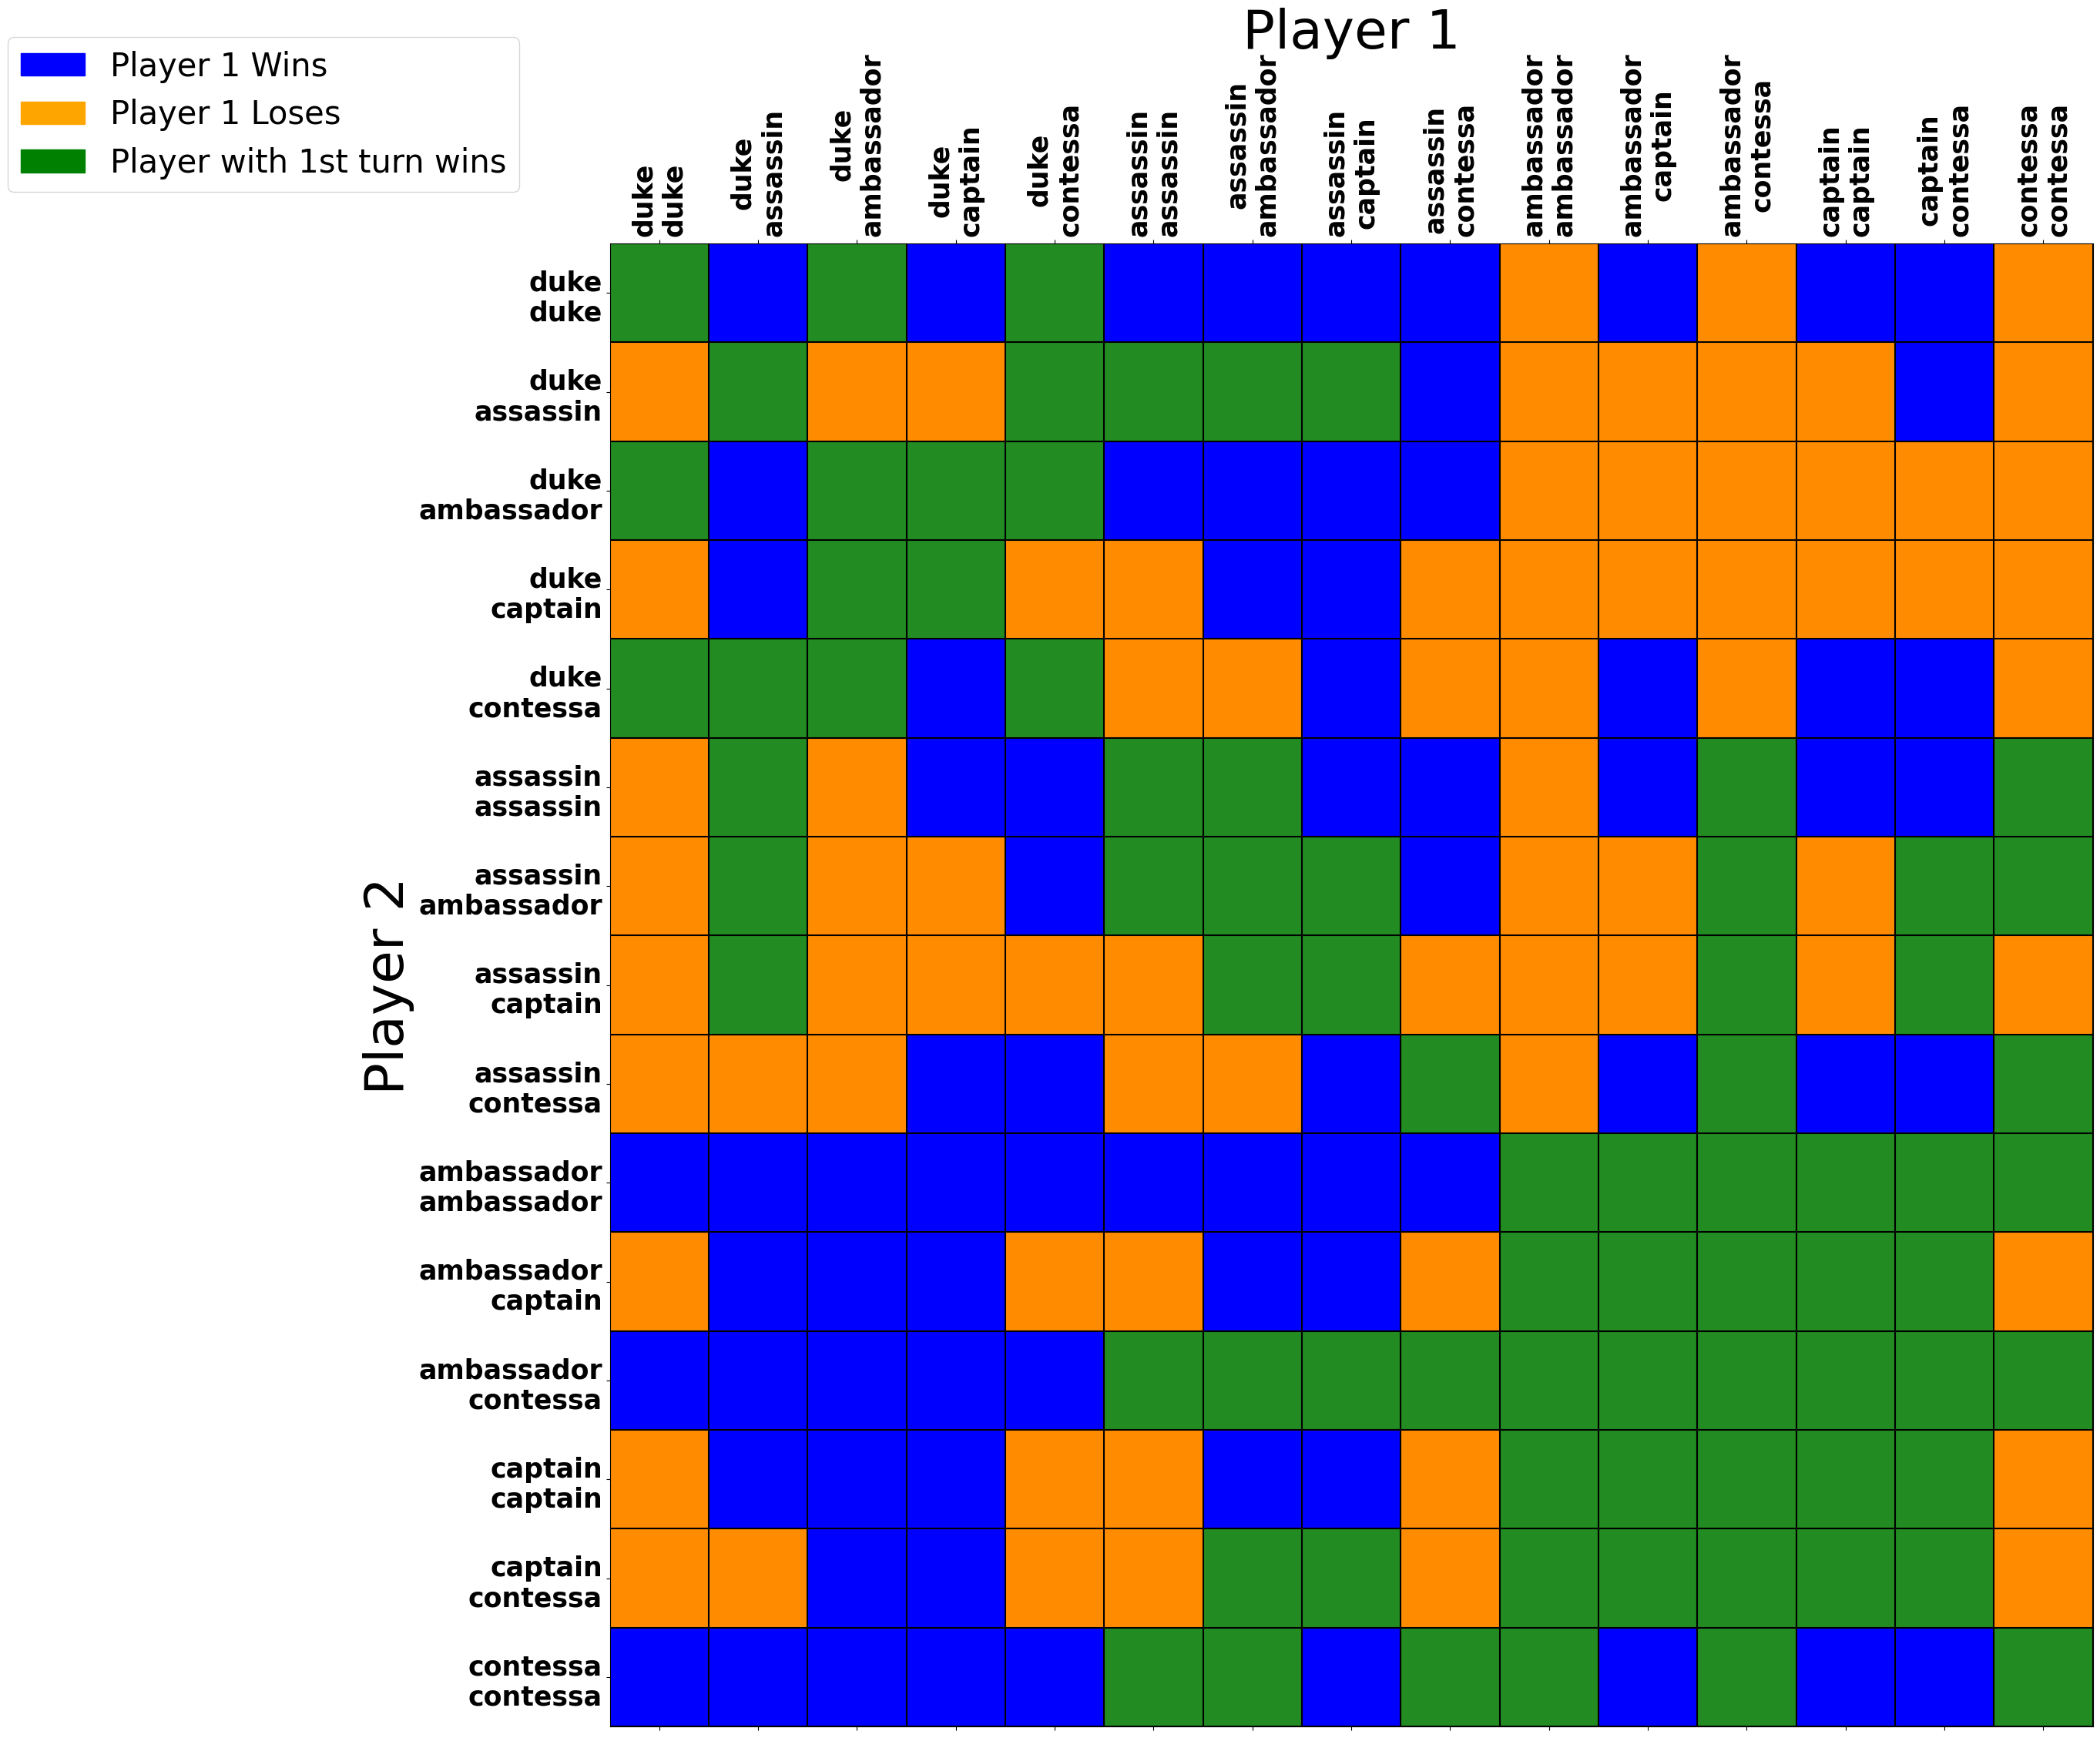

In [6]:
# cards_pair_labels = list(itertools.combinations(constants.CARDS, 2))
# cards_pair_labels.extend([(card, card) for card in constants.CARDS])
card_pair_labels = [('duke', 'duke'), ('duke', 'assassin'), ('duke', 'ambassador'), ('duke', 'captain'), ('duke', 'contessa'), ('assassin', 'assassin'), ('assassin', 'ambassador'), ('assassin', 'captain'), ('assassin', 'contessa'),('ambassador', 'ambassador'),  ('ambassador', 'captain'), ('ambassador', 'contessa'), ('captain', 'captain'), ('captain', 'contessa'), ('contessa', 'contessa')]
get_grid_fig(card_pair_labels, "../data/matchup_grid.png")

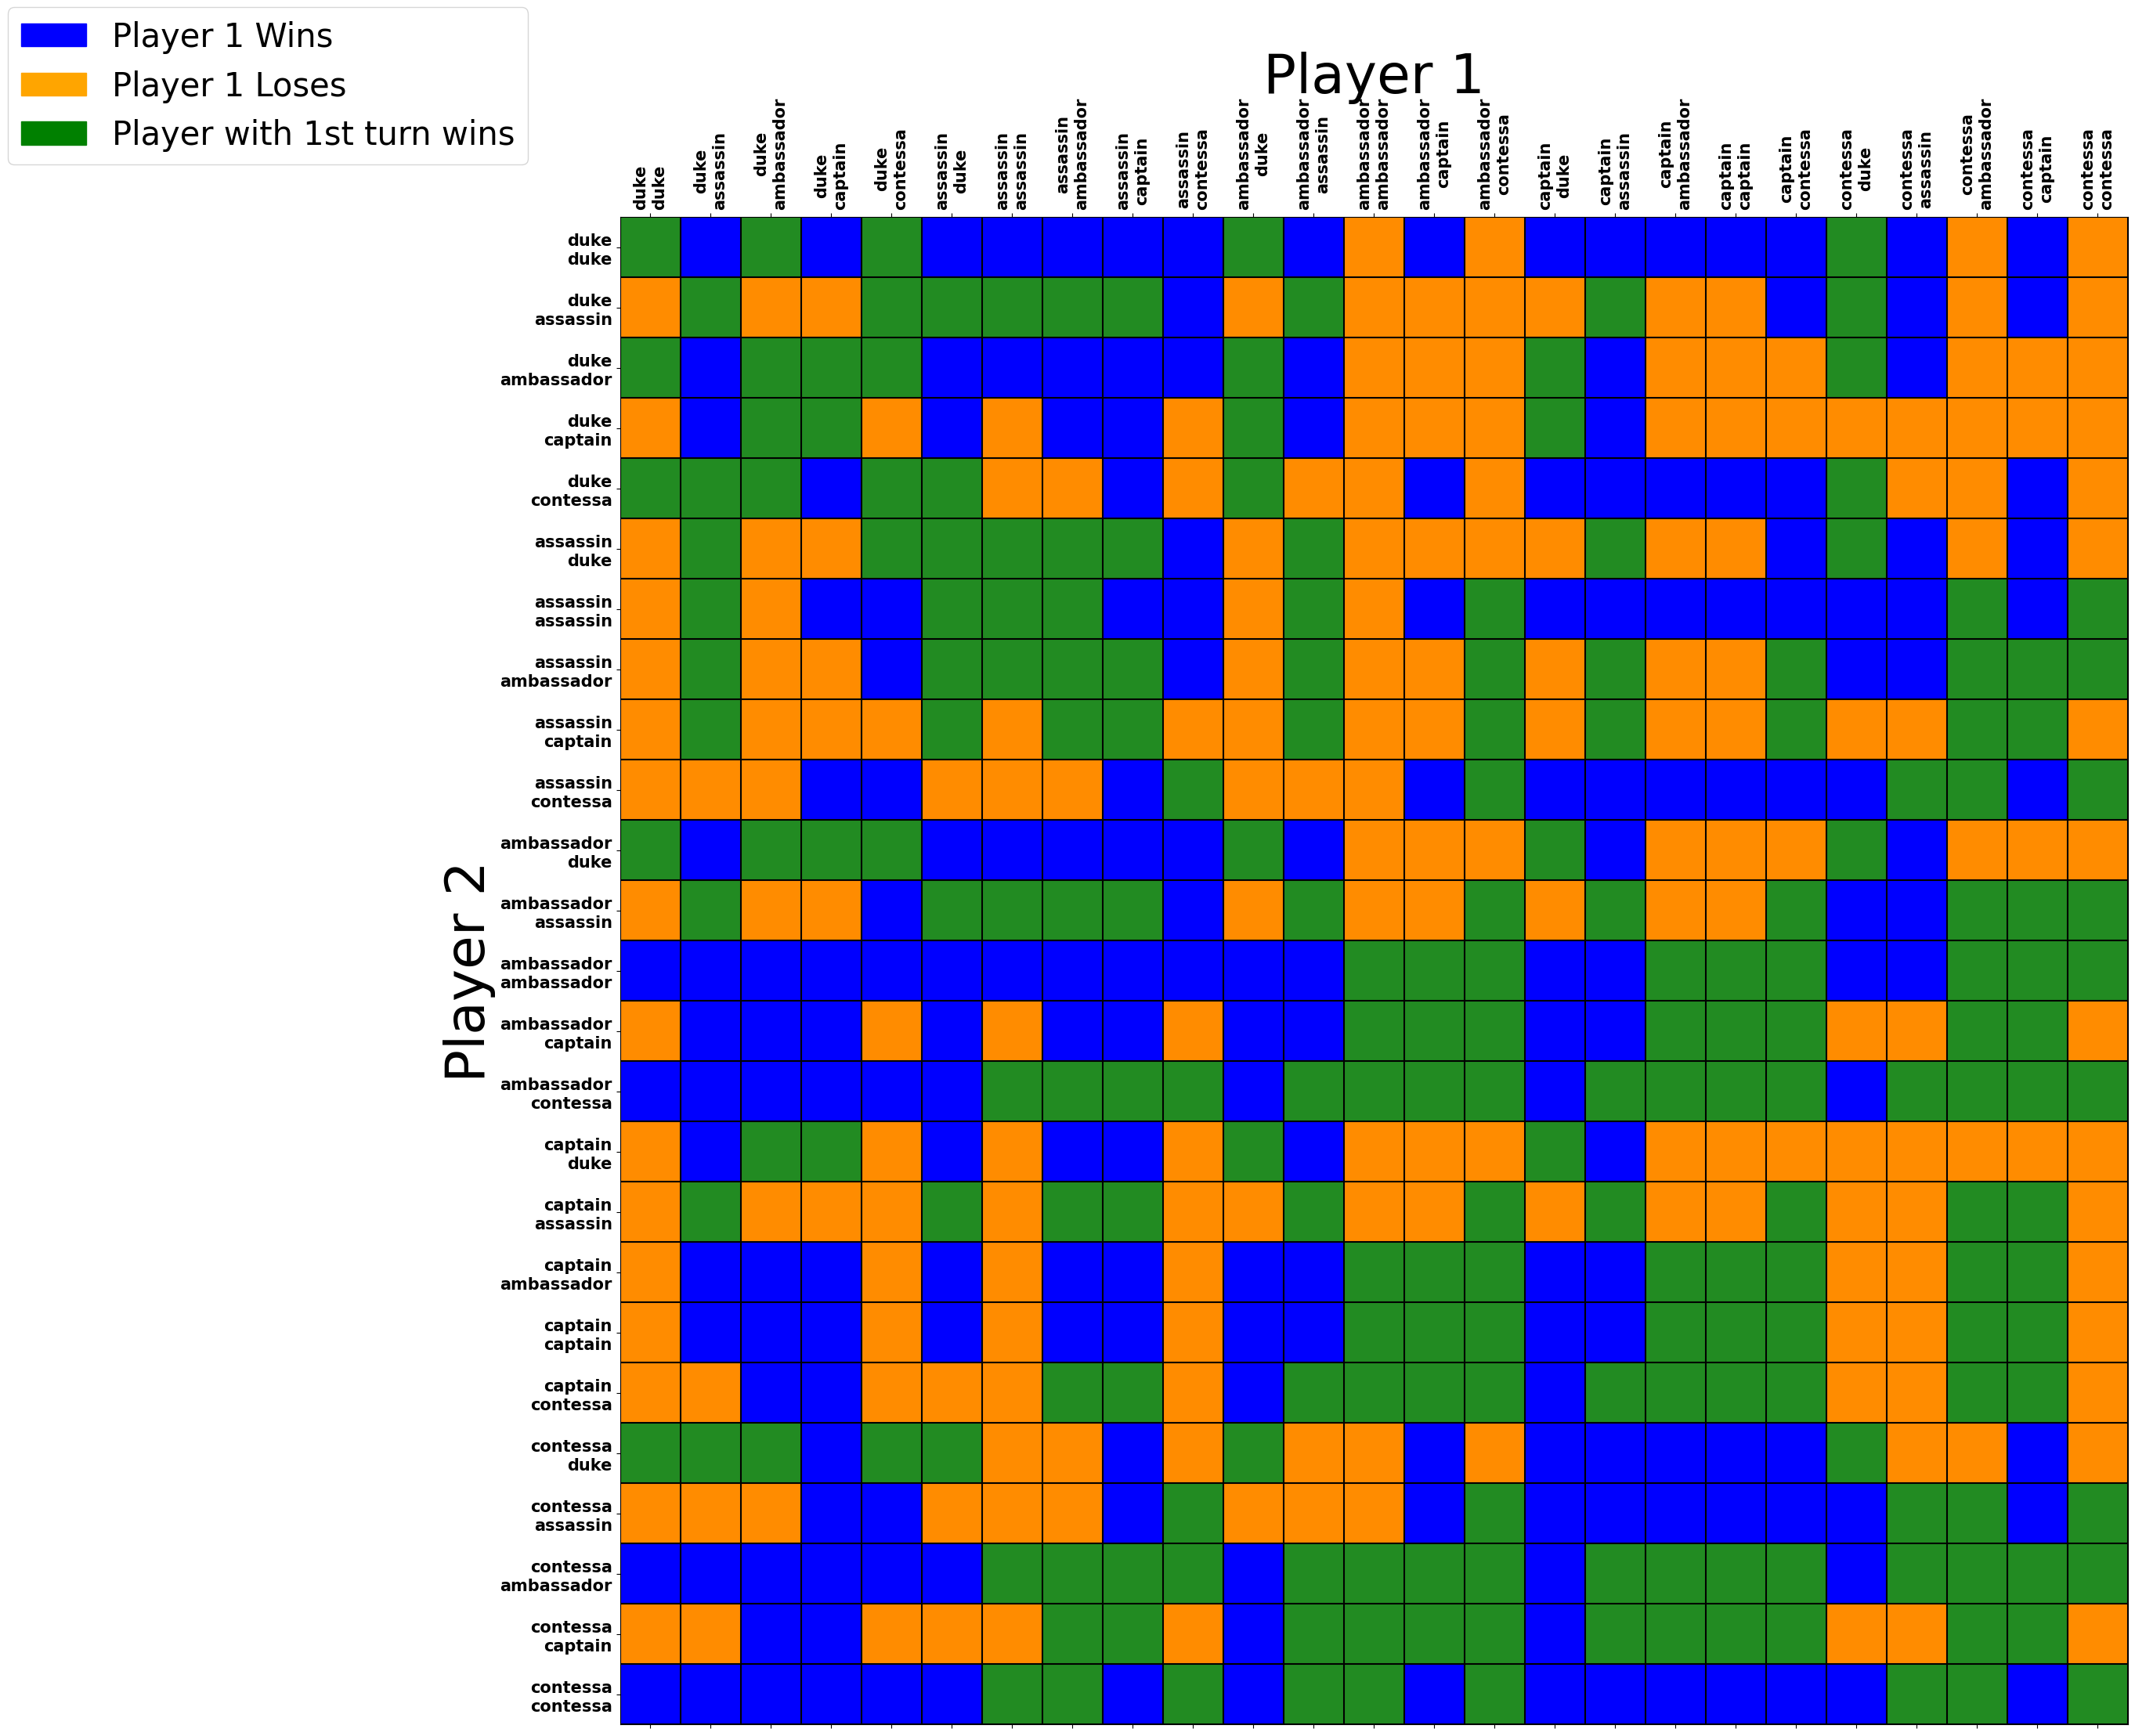

In [7]:
card_pair_labels = [('duke', 'duke'), ('duke', 'assassin'), ('duke', 'ambassador'), ('duke', 'captain'), ('duke', 'contessa'), ('assassin', 'duke'), ('assassin', 'assassin'), ('assassin', 'ambassador'), ('assassin', 'captain'), ('assassin', 'contessa'), ('ambassador', 'duke'), ('ambassador', 'assassin'), ('ambassador', 'ambassador'), ('ambassador', 'captain'), ('ambassador', 'contessa'), ('captain', 'duke'), ('captain', 'assassin'), ('captain', 'ambassador'), ('captain', 'captain'), ('captain', 'contessa'), ('contessa', 'duke'), ('contessa', 'assassin'), ('contessa', 'ambassador'), ('contessa', 'captain'), ('contessa', 'contessa')]
get_grid_fig(card_pair_labels, "../data/matchup_grid_full.png", fontsize=15)

In [8]:
def generate_win_count_graph(path):
    card_pair_labels = [('duke', 'duke'), ('duke', 'assassin'), ('duke', 'ambassador'), ('duke', 'captain'), ('duke', 'contessa'), ('assassin', 'assassin'), ('assassin', 'ambassador'), ('assassin', 'captain'), ('assassin', 'contessa'),('ambassador', 'ambassador'),  ('ambassador', 'captain'), ('ambassador', 'contessa'), ('captain', 'captain'), ('captain', 'contessa'), ('contessa', 'contessa')]
    dukew = 0
    assassinw = 0
    ambassadorw = 0
    captainw = 0
    contessaw = 0
    for i, pair_1 in enumerate(card_pair_labels):
        for j, pair_2 in enumerate(card_pair_labels):
            winner = 3 if matchup_results[pair_1][pair_2] == matchup_results[pair_2][pair_1] else matchup_results[pair_1][pair_2]
            if 'duke' in pair_1 and winner == '1':
                dukew += 1
            if 'assassin' in pair_1 and winner == '1':
                assassinw += 1
            if 'ambassador' in pair_1 and winner == '1':
                ambassadorw += 1
            if 'captain' in pair_1 and winner == '1':
                captainw += 1
            if 'contessa' in pair_1 and winner == '1':
                contessaw += 1

    x = ['Duke', 'Assassin', 'Ambassador', 'Captain', 'Contessa']
    y = [dukew, assassinw, ambassadorw, captainw, contessaw]
    plt.bar(x, y)
    for i in range(len(x)):
            plt.text(i-0.1,y[i]+0.3,y[i])
    plt.title("Number of winning matchups for each card")
    plt.ylabel("Winning Matchups")
    plt.savefig(path)
    plt.show()

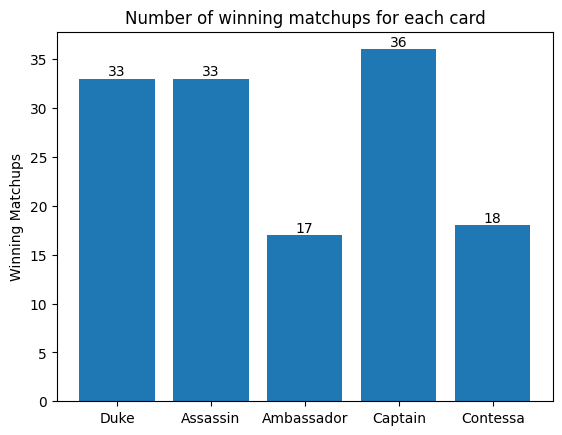

In [9]:
generate_win_count_graph("../data/win_count_graph.png")

In [10]:
card_pair_labels = [('duke', 'duke'), ('duke', 'assassin'), ('duke', 'ambassador'), ('duke', 'captain'), ('duke', 'contessa'), ('assassin', 'assassin'), ('assassin', 'ambassador'), ('assassin', 'captain'), ('assassin', 'contessa'),('ambassador', 'ambassador'),  ('ambassador', 'captain'), ('ambassador', 'contessa'), ('captain', 'captain'), ('captain', 'contessa'), ('contessa', 'contessa')]

def get_matchup_winning_percent_graph(path):
    winning_dict = {}

    for t in card_pair_labels:
        winning_dict[t] = 0

    winner_array = np.zeros((len(card_pair_labels), len(card_pair_labels)))
    total_matchups = 0
    for i, pair_1 in enumerate(card_pair_labels):
        for j, pair_2 in enumerate(card_pair_labels):
            winner_array[i][j] = 3 if matchup_results[pair_1][pair_2] == matchup_results[pair_2][pair_1] else matchup_results[pair_1][pair_2]
            if winner_array[i][j] == 1:
                winning_dict[pair_1] += 1
            if winner_array[i][j] == 2:
                winning_dict[pair_2] += 1
            if winner_array[i][j] == 3:
                # We only want to increment the count for pair1 here because each card will be pair1 for a loop so otherwise we double count
                winning_dict[pair_1] += 1
        total_matchups += 1

    winning_dict = {key: value / (total_matchups * 2) for key, value in winning_dict.items()}
    card_pair_labels_pretty = [f"{label[0]} {label[1]}" for label in card_pair_labels]
    winning_ratios = [r for r in winning_dict.values()]

    y_axis = np.arange(len(card_pair_labels))
    plt.barh(y_axis, winning_ratios, color='orange', height=0.4)
    plt.yticks(y_axis, card_pair_labels_pretty, fontweight='bold')

    # Set the labels and title
    plt.ylabel("Matchups")
    plt.xlabel("Winning Percentage")
    plt.title("Matchups vs Winning Percentages")
    plt.grid(linestyle='-', linewidth=.3)

    plt.savefig(path, bbox_inches='tight')
    plt.show()
    print(total_matchups)

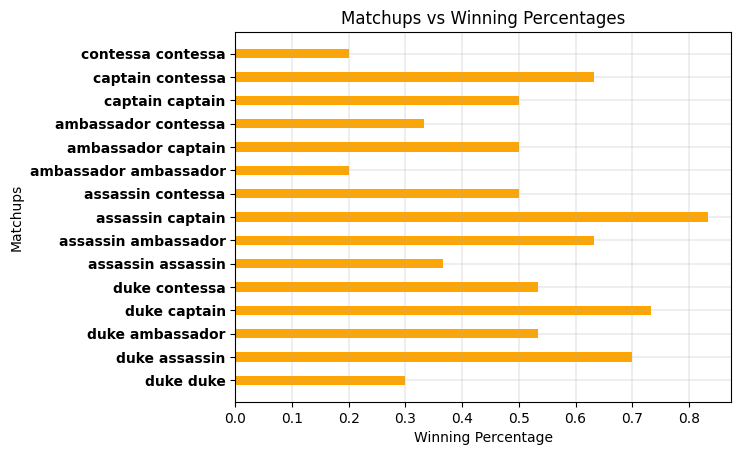

15


In [11]:
get_matchup_winning_percent_graph("../data/winning_matchup_ratios.png")

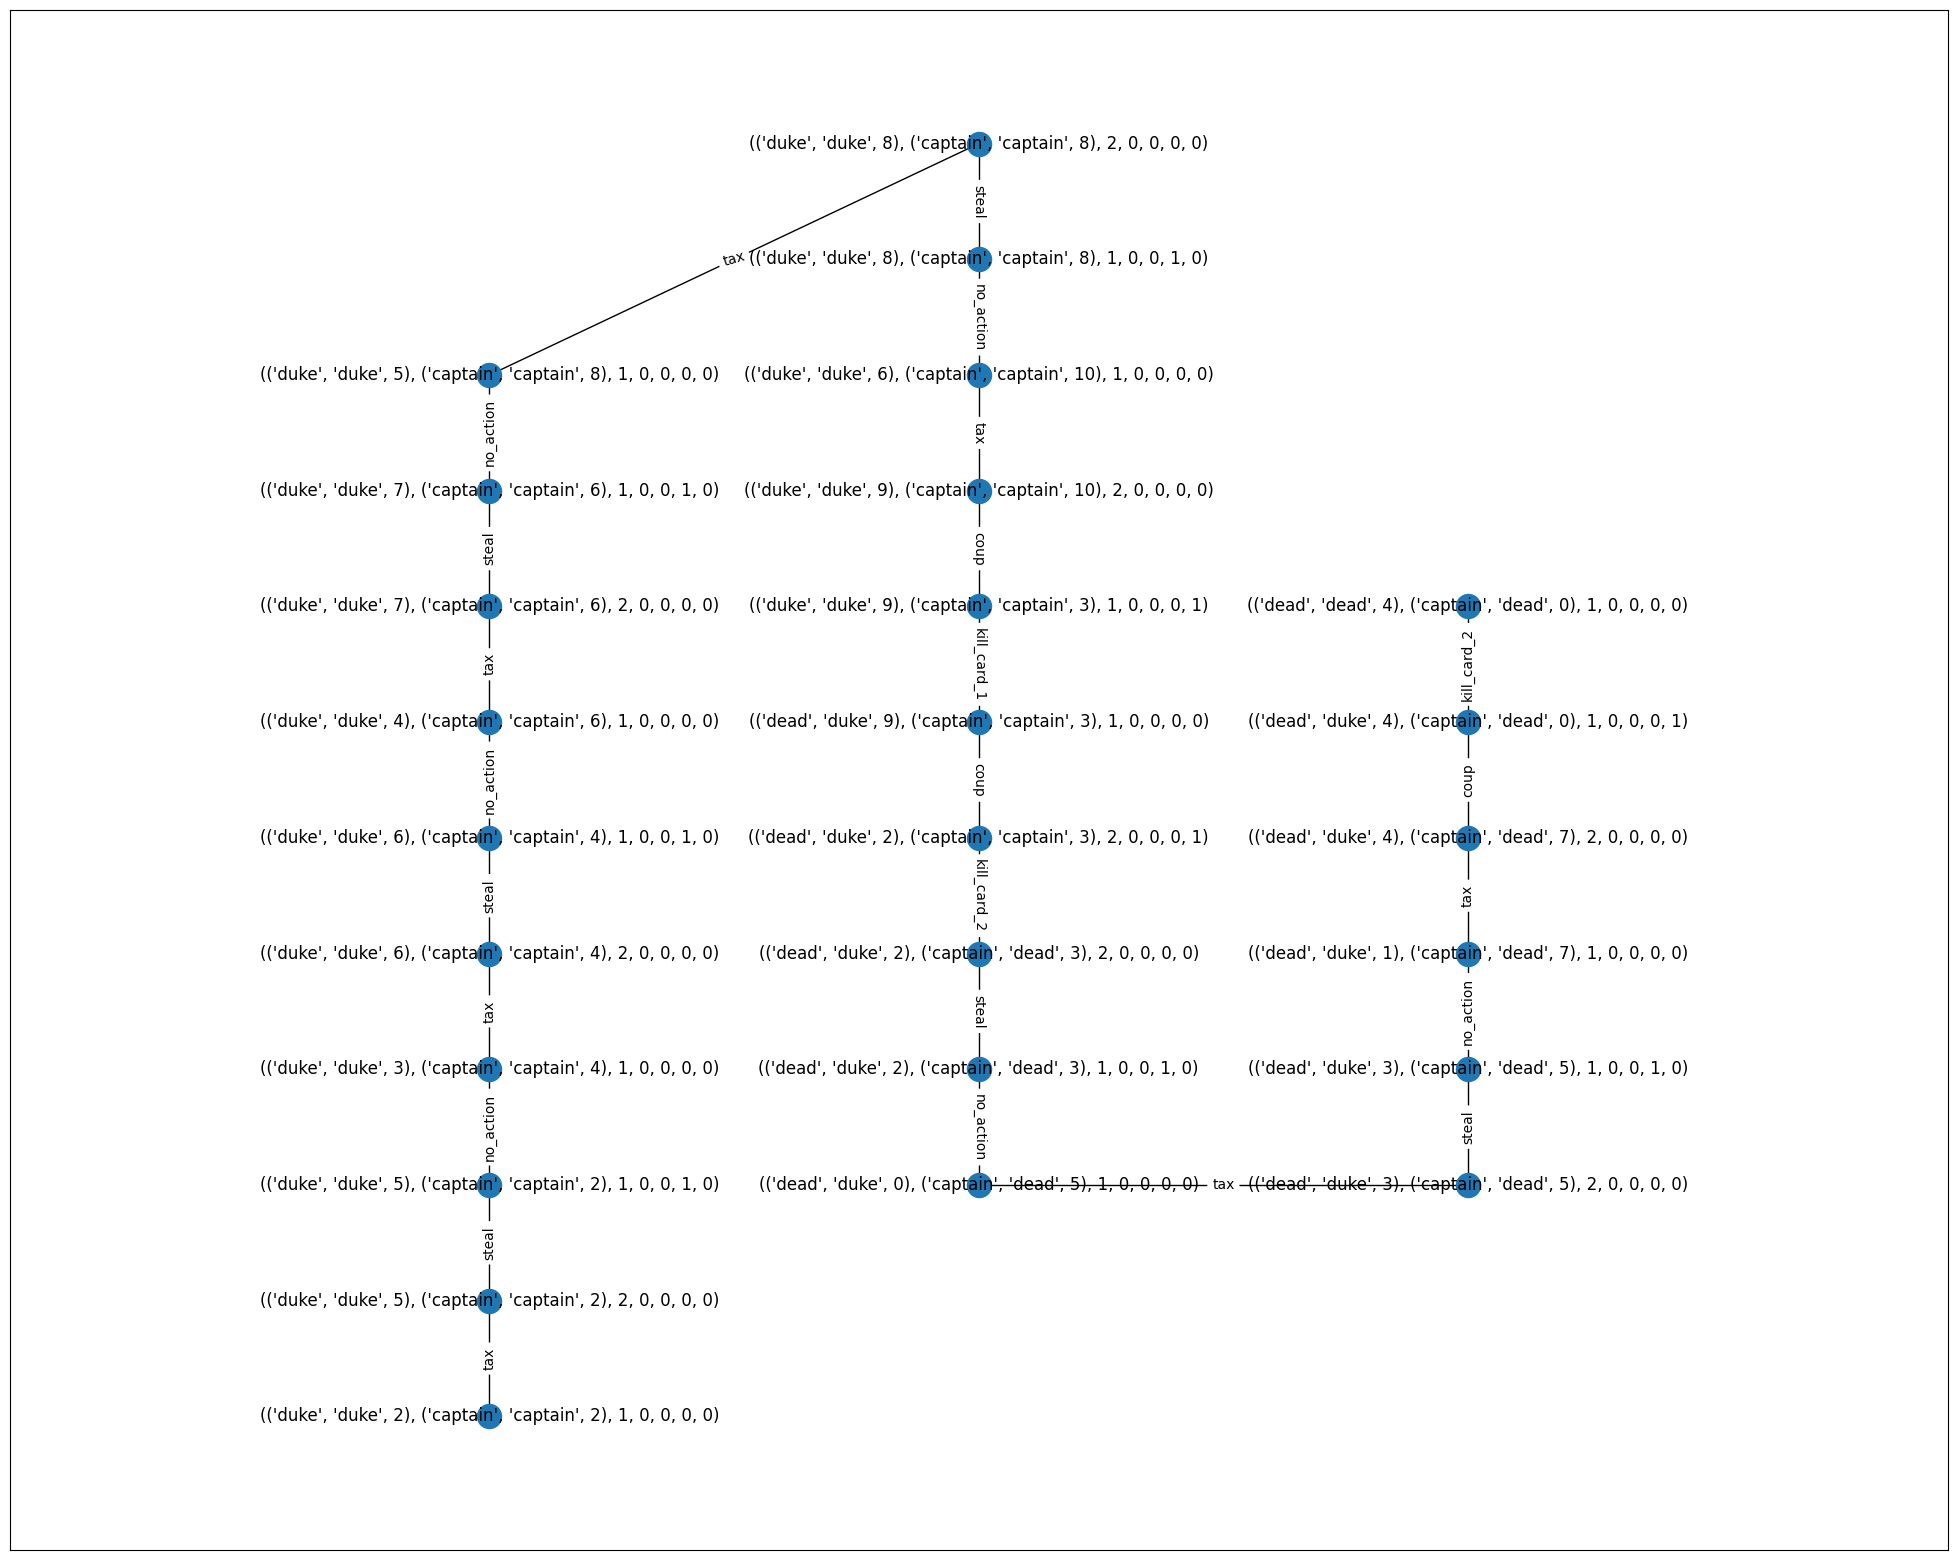

In [12]:
def get_run_graph(path):
    run = list()
    with open(path, 'r') as file:
        for line in file:
            run.append(line)
            nodes = [node[:-1] for i, node in enumerate(run) if i % 2 == 0]
            edges = [edge[0:-1] for i, edge in enumerate(run) if i % 2 == 1]

    plt.figure(figsize=(25,20))
    G=nx.Graph()
    G.add_nodes_from(nodes)
    positions = dict()
    edge_labels = dict()

    last_node = None
    j = 0
    for i, node in enumerate(nodes):
        positions[node] = [j, i%10+j] if j%2 == 0 else [j, 10-i%10+j]
        if last_node is not None and last_node != node:
            G.add_edge(last_node, node)
            edge_labels[(last_node, node)] = edges[i-1]
        last_node = node
        if i % 10 == 9:
            j += 1
    nx.draw_networkx(G,pos=positions)
    nx.draw_networkx_edge_labels(G, positions, edge_labels=edge_labels, font_color='black', font_size=10)
    save_path = path[0:-4] + ".png"
    plt.margins(x=0.4)
    plt.savefig(save_path)

get_run_graph("../data/DDvCC_run.txt")